In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
sys.path.insert(0, '../')

In [3]:
import keras
from common.nn import *
from common.eval import *
import common

Using TensorFlow backend.


In [4]:
import sys
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
sys.path.insert(0, '../')
from common.utils import *
from common.utils import imread_and_resize_cv2 as imread_and_resize

In [5]:
import numpy as np
import scipy as sp
import cv2
import datetime
from tqdm import tqdm
from glob2 import glob

In [6]:
resolutions = [(64*i,192*i) for i in range(1,5)][::-1]

In [7]:
n_rows,n_cols = resolutions[2]
im_shape = (n_rows,n_cols)
n_channels = 3
input_shape = (n_rows,n_cols,n_channels)

In [8]:
n_rows,n_cols

(64, 192)

In [9]:
boundary_only =  False

In [10]:
net = get_custom_unet(input_shape=input_shape,n_conv=8,act='relu',bottle_idx=5)
        
history = []

In [11]:
DATA_ROOT = '/fasthome/cvlab/RDC/rdc-datasets/'
TRAIN_DIR = DATA_ROOT+'/SegDataSet_Cityscape_Kitti_Kia_Wilddash/'
im_paths = np.array(glob(TRAIN_DIR + 'resized_image/'  +  '*.*'))
masks_paths = np.array(glob(TRAIN_DIR + 'resized_label/' +  '*.*'))
kia_idx = in_filename(im_paths)
kia_match = np.ones(len(im_paths), dtype=bool)
kia_match[kia_idx] = False
kia_im_paths = im_paths[kia_idx]
kia_mask_paths = masks_paths[kia_idx]
im_paths = im_paths[kia_match]
masks_paths = masks_paths[kia_match]

In [12]:
OFFROAD_DIR = DATA_ROOT + '/OffRoad/'
im_off_paths = np.array(glob(OFFROAD_DIR + '/image/'  +  '*.*'))
masks_off_paths = np.array(glob(OFFROAD_DIR + '/label/'  +  '*.*'))

In [13]:
im_paths_train, im_paths_val, masks_paths_train,masks_paths_val = train_test_split(im_paths, masks_paths,
                                                                                   random_state=42,test_size=0.1)

X_train = np.array([imread_and_resize(e,im_shape,n_channels == 3) for e in tqdm(im_paths_train)])
y_train = np.array([imread_and_resize(e,im_shape,False) for e in tqdm(masks_paths_train)])

X_val = np.array([imread_and_resize(e,im_shape,n_channels == 3) for e in tqdm(im_paths_val)])
y_val = np.array([imread_and_resize(e,im_shape,False) for e in tqdm(masks_paths_val)])

X_off = np.array([imread_and_resize(e,im_shape,n_channels == 3) for e in tqdm(im_off_paths)])
y_off = np.array([imread_and_resize(e,im_shape,False) for e in tqdm(masks_off_paths)])

y_train,y_val,y_off = binarize_mask(y_train),binarize_mask(y_val),binarize_mask(y_off)

if boundary_only:
    y_train = np.array([boundary_mask(e) for e in y_train])
    y_val = np.array([boundary_mask(e) for e in y_val])

100%|██████████| 66/66 [00:00<00:00, 118.54it/s]


In [14]:
X_kia = np.array([imread_and_resize(e,im_shape,n_channels == 3) for e in tqdm(kia_im_paths)])
y_kia = np.array([imread_and_resize(e,im_shape,False) for e in tqdm(kia_mask_paths)])
y_kia = binarize_mask(y_kia)
if boundary_only:
    y_kia = np.array([boundary_mask(e) for e in y_kia])

100%|██████████| 9/9 [00:00<00:00, 208.59it/s]


In [15]:
do_parallel = False

In [16]:

losses=[dice_crossentopy_loss]
metrics = [f1_score,dice_coef]
net.compile(optimizer=keras.optimizers.Adam(lr=0.0002),
                  loss = losses,metrics=metrics)
history.append(net.fit(X_train,expand(y_train),validation_data=(X_val,expand(y_val)),
    epochs=15,
    initial_epoch=0,
    batch_size=2,
    verbose=1
))

Train on 3370 samples, validate on 375 samples
Epoch 1/15
3370/3370 [==============================] - 42s 12ms/step - loss: 0.6030 - f1_score: 0.8393 - dice_coef: 0.7927 - val_loss: 0.4570 - val_f1_score: 0.8773 - val_dice_coef: 0.8246
Epoch 2/15
3370/3370 [==============================] - 43s 13ms/step - loss: 0.3881 - f1_score: 0.8930 - dice_coef: 0.8599 - val_loss: 0.3802 - val_f1_score: 0.8934 - val_dice_coef: 0.8634
Epoch 3/15
3370/3370 [==============================] - 43s 13ms/step - loss: 0.3372 - f1_score: 0.9063 - dice_coef: 0.8776 - val_loss: 0.3736 - val_f1_score: 0.9030 - val_dice_coef: 0.8850
Epoch 4/15
3370/3370 [==============================] - 43s 13ms/step - loss: 0.3051 - f1_score: 0.9152 - dice_coef: 0.8895 - val_loss: 0.3190 - val_f1_score: 0.9128 - val_dice_coef: 0.8836
Epoch 5/15
3370/3370 [==============================] - 40s 12ms/step - loss: 0.2808 - f1_score: 0.9217 - dice_coef: 0.8981 - val_loss: 0.3056 - val_f1_score: 0.9154 - val_dice_coef: 0.8841
Epo

## Validation

In [17]:
pred_probs = net.predict(X_val,batch_size=16,verbose=1)

375/375 [==============================] - 1s 2ms/step


In [18]:
pred_probs = squeeze(pred_probs)

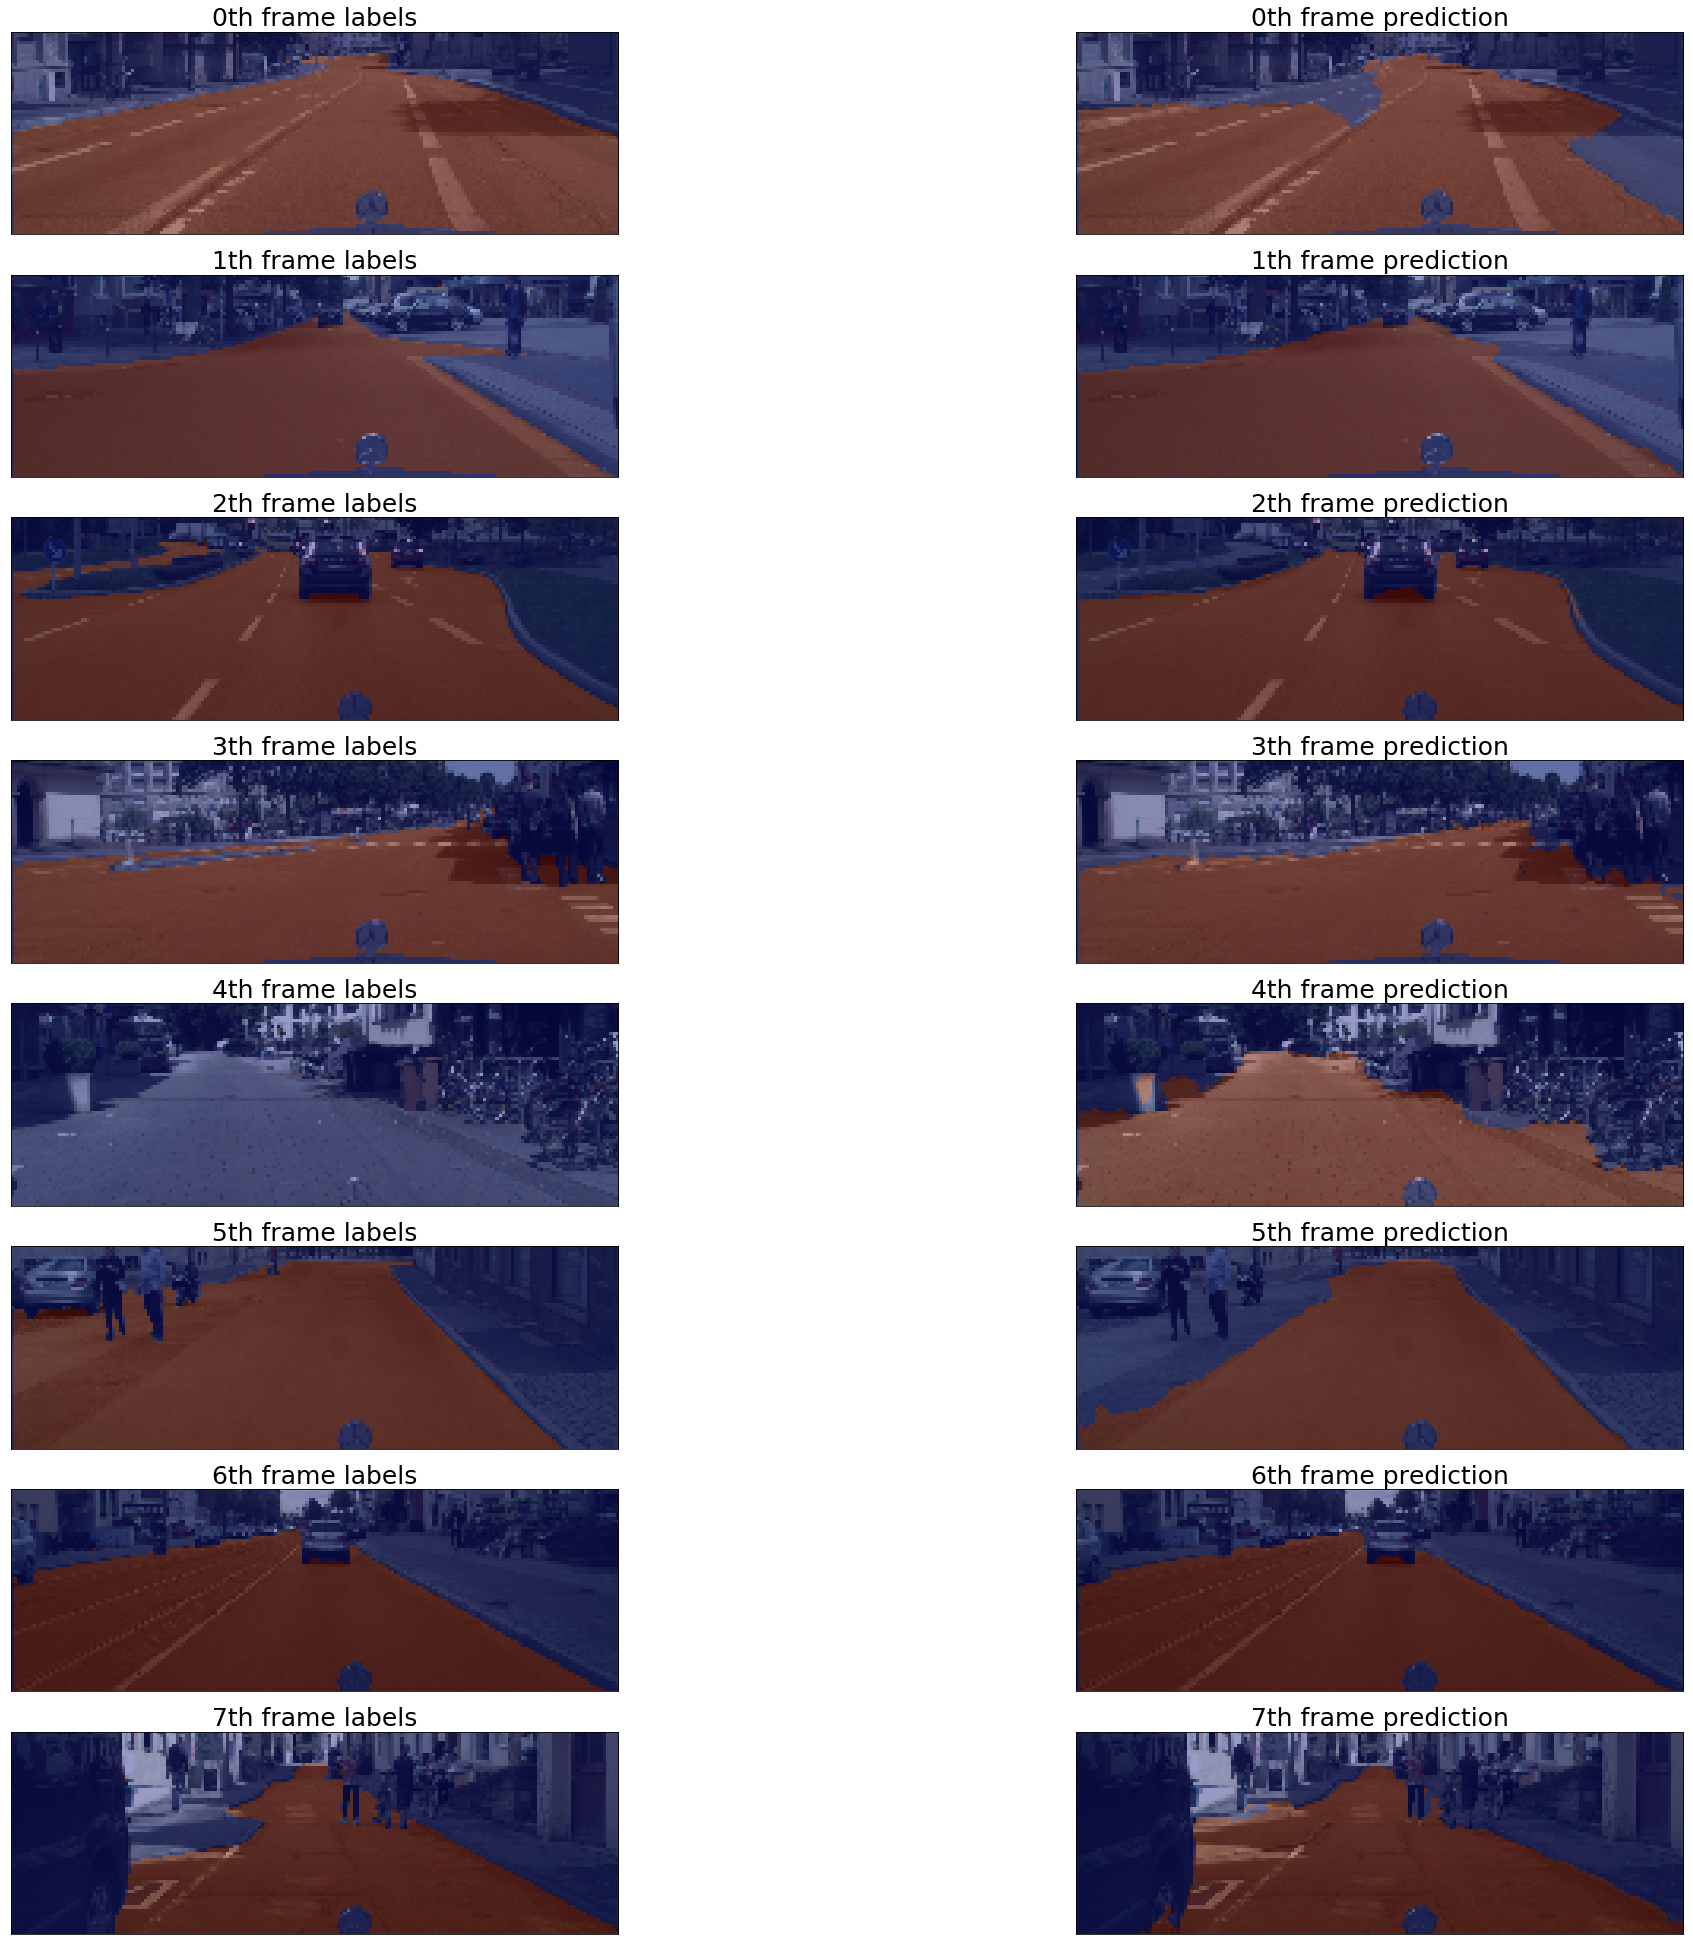

In [19]:
masks_pred = (pred_probs > 0.5).astype('uint8')

ridx = np.random.permutation(len(X_val))

figure(facecolor='white')
plt.figure(figsize=(35,35),facecolor='white')
k = 0
for fr_idx in range(16):
    j = ridx[k]
    plt.subplot(8, 2, fr_idx+1,facecolor='white')
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)
    if fr_idx % 2 == 0:
        title('%sth frame labels' % k,fontsize=25)
        imshow(X_val[j][...,::-1])
        imshow(y_val[j],cmap='jet',alpha=0.4)
    else:
        title('%sth frame prediction' % k,fontsize=25)
        imshow(X_val[j][...,::-1])
        imshow(masks_pred[j],cmap='jet',alpha=0.4)
        k += 1

## Test Kia

In [20]:
pred_probs_kia = squeeze(net.predict(X_kia,batch_size=2,verbose=1))
masks_pred_kia = (pred_probs_kia > 0.5).astype('uint8')

9/9 [==============================] - 0s 3ms/step


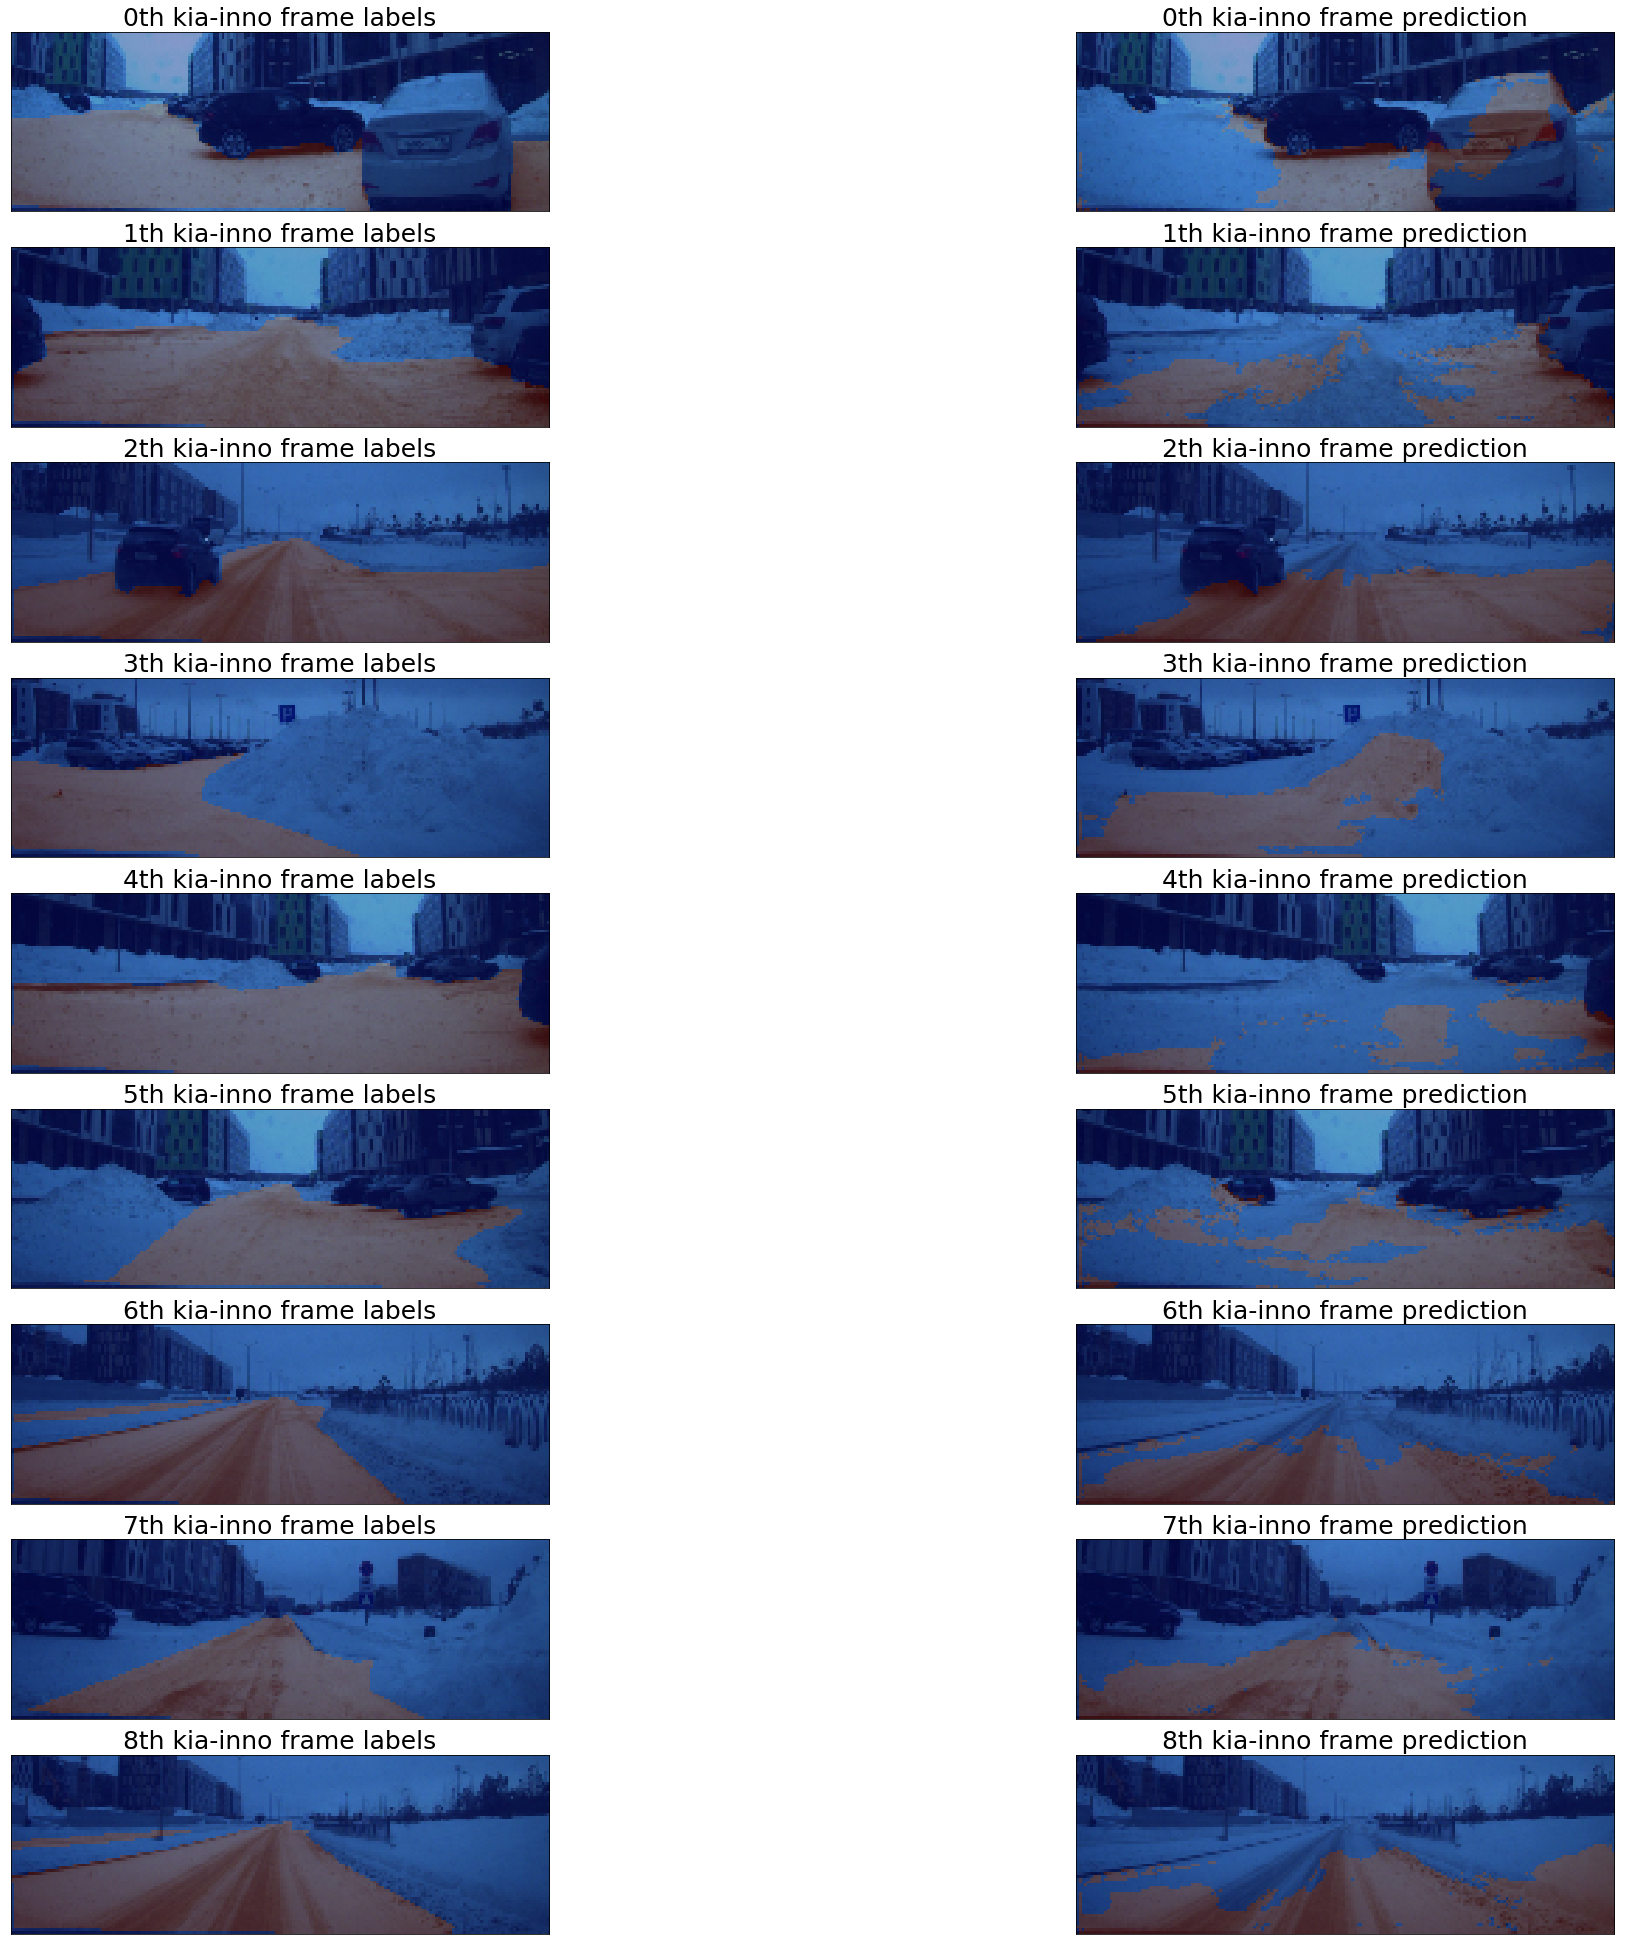

In [21]:
figure(facecolor='white')
plt.figure(figsize=(35,35),facecolor='white')
k = 0
idxs = np.arange(len(X_kia))
for fr_idx in range(2*len(X_kia)):
    j = idxs[k]
    plt.subplot(9, 2, fr_idx+1,facecolor='white')
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)

    if fr_idx % 2 == 0:
        title('%sth kia-inno frame labels' % k,fontsize=25)
        imshow(X_kia[j][...,::-1])
        imshow(y_kia[j],cmap='jet',alpha=0.4)
    else:
        title('%sth kia-inno frame prediction' % k,fontsize=25)
        imshow(X_kia[j][...,::-1])
        imshow(masks_pred_kia[j],cmap='jet',alpha=0.4)
        k += 1

## Test Off Road

In [22]:
pred_probs_off = squeeze(net.predict(X_off,batch_size=2,verbose=1))
masks_pred_off = (pred_probs_off > 0.5).astype('uint8')

66/66 [==============================] - 0s 3ms/step


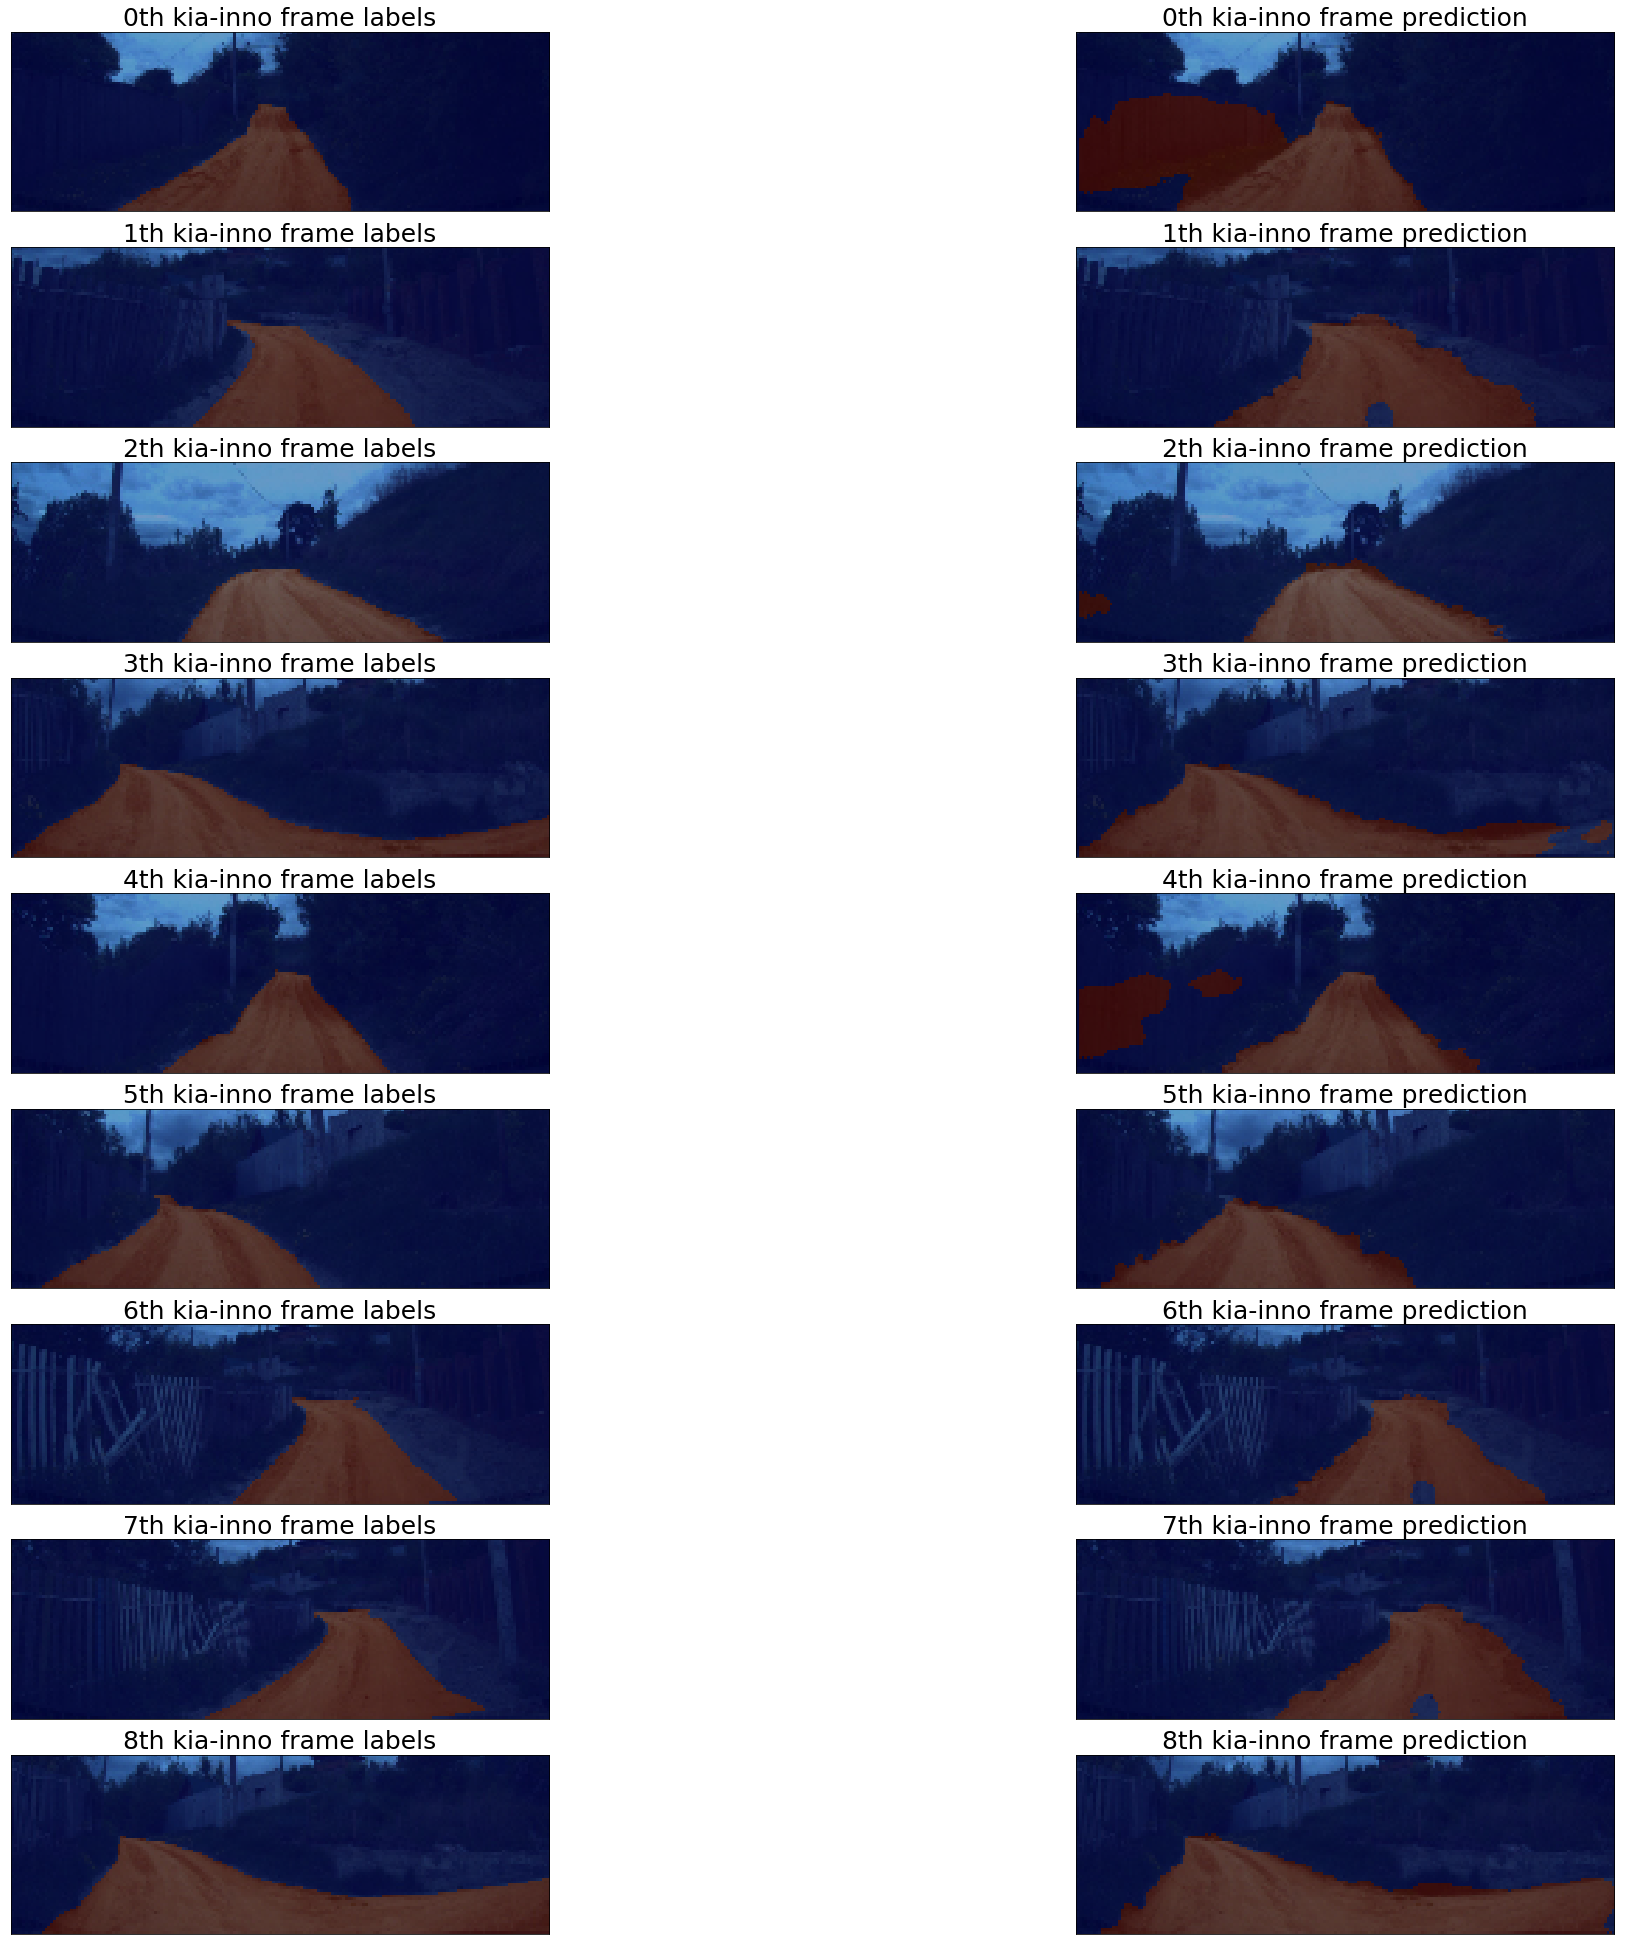

In [23]:
figure(facecolor='white')
plt.figure(figsize=(35,35),facecolor='white')
k = 0
idxs_off = np.arange(len(X_off))
for fr_idx in range(2*9):
    j = idxs_off[k]
    plt.subplot(9, 2, fr_idx+1,facecolor='white')
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)

    if fr_idx % 2 == 0:
        title('%sth kia-inno frame labels' % k,fontsize=25)
        imshow(X_off[j][...,::-1])
        imshow(y_off[j],cmap='jet',alpha=0.4)
    else:
        title('%sth kia-inno frame prediction' % k,fontsize=25)
        imshow(X_off[j][...,::-1])
        imshow(masks_pred_off[j],cmap='jet',alpha=0.4)
        k += 1